In [272]:
import numpy as np
import matplotlib
matplotlib.use(backend="TkAgg")
import matplotlib.pyplot as plt
import pyart
from pathlib import Path
import radarIQ
from radarIQ.viz.polarGridPlotting import rangeRings, azimuthSpiderweb
from radarIQ.viz import iSpectrumDealias, savedSpectrumDealias
import pickle

root = Path().cwd()

In [273]:
cfTime = 39
sampDeg = 0.5
beamOverlap = 0
t = radarIQ.io.raxpolrkc.staticCfradNum2RkcNum(root, 'may232024', cfTime, sampDeg, beamOverlap)
startCfrad = radarIQ.io.raxpolrkc.staticGetExistingCfrad(root, 'may232024', t, sampDeg, beamOverlap)
radar = pyart.io.read(startCfrad)
az_vals = np.arange(0., 360., sampDeg)
range_vals = radar.range['data']
range_vals_km = range_vals/1000

In [274]:
%matplotlib tk

disp = radarIQ.viz.iPyart(startCfrad.parent, cfTime)

In [275]:
meso_center = {
    'r_km': None,
    'az': None,
    'x': None,
    'y': None
}
spectrum_range = {
    'az': None,
    'ranges': [None, None]
}
unfoldSaveData = None

In [276]:
#stovepipe inflow side
# cfTime = 79
# meso_center = {'r_km': 9.090000361204147, 'az': 34.0, 'x': 5.083063694531885, 'y': 7.535951833977139}
# spectrum_range = {'az': 31.5, 'ranges': [6.975, 11.895]}
# with open(root/"cases"/"may232024"/"unfoldSaveData"/"stovepipeInflowSide.bin", 'rb') as f:
#         unfoldSaveData = pickle.load(f)

In [277]:
#stovepipe outflow side
# cfTime = 79
# meso_center = {'r_km': 9.105000361800194, 'az': 34.0, 'x': 5.09145158841725, 'y': 7.548387398059609}
# spectrum_range = {'az': 38.5, 'ranges': [6.975, 11.895]}
# with open(root/"cases"/"may232024"/"unfoldSaveData"/"stovepipeOutflowSide.bin", 'rb') as f:
#         unfoldSaveData = pickle.load(f)

In [278]:
#2 deg dbl fold
# cfTime = 42
# meso_center = {'r_km': 4.320000171661377, 'az': 347.5, 'x': -0.9350191693669263, 'y': 4.217598918350429}
# spectrum_range = {'az': 343.0, 'ranges': [2.565, 6.075], 'iaz': 56, 'iranges': [85, 202]}
# with open(root/"cases"/"may232024"/"unfoldSaveData"/"2degDblFold.bin", 'rb') as f:
#         unfoldSaveData = pickle.load(f)

In [279]:
#0 deg dbl fold
# cfTime = 39
meso_center = {'r_km': 4.1700001657009125, 'az': 340.5, 'x': -1.3919746583169272, 'y': 3.930815174050939}
spectrum_range = {'az': 337.0, 'ranges': [3.165, 6.885]}

In [280]:
def dblclick(event):
    if event.dblclick:
        global t
        x = event.xdata
        y = event.ydata
        if meso_center['r_km'] is None:
            r_km, az = radarIQ.misc.coordConvert.cart2polar(x,y)
            iaz = np.argmin(np.abs(az_vals - az))
            az = az_vals[iaz]

            dr_km = range_vals_km[1]-range_vals_km[0]
            r_km = (dr_km/2) * round(r_km / (dr_km/2))

            plt_x, plt_y = radarIQ.misc.coordConvert.polar2cart(r_km, az)

            disp.plot(('scatter', plt_x, plt_y, 'b'))

            meso_center['r_km'] = r_km
            meso_center['az'] = az
            meso_center['x'] = plt_x
            meso_center['y'] = plt_y
            disp.setCustomTitle("Doubleclick to set spectrum azimuth.")
        elif spectrum_range['az'] is None:
            _, az = radarIQ.misc.coordConvert.cart2polar(x,y)
            
            d_az = np.abs(az_vals - az)
            iaz = np.argmin(d_az)

            endx, endy = radarIQ.misc.coordConvert.polar2cart(range_vals_km[-1], az_vals[iaz])
            plt_x = [0, endx]
            plt_y = [0, endy]

            disp.plot(('plot', plt_x, plt_y, 'r'))

            spectrum_range['az'] = az_vals[iaz]
            disp.setCustomTitle("Doubleclick to set spectrum range bound.")
        elif spectrum_range['ranges'][0] is None:
            r_km, _ = radarIQ.misc.coordConvert.cart2polar(x,y)

            dr_km = np.abs(range_vals_km - r_km)
            irange = np.argmin(dr_km)
            
            plt_x, plt_y = radarIQ.misc.coordConvert.polar2cart(range_vals_km[irange], spectrum_range['az'])

            disp.plot(('scatter', plt_x, plt_y, 'g'))

            spectrum_range['ranges'][0] = range_vals_km[irange]
            disp.setCustomTitle("Doubleclick to set other spectrum range bound.")
        elif spectrum_range['ranges'][1] is None:
            r_km, _ = radarIQ.misc.coordConvert.cart2polar(x,y)

            dr_km = np.abs(range_vals_km - r_km)
            irange = np.argmin(dr_km)

            plt_x, plt_y = radarIQ.misc.coordConvert.polar2cart(range_vals_km[irange], spectrum_range['az'])

            disp.plot(('scatter', plt_x, plt_y, 'g'))

            spectrum_range['ranges'][1] = range_vals_km[irange]
            spectrum_range['ranges'].sort()

            xstart, ystart = radarIQ.misc.coordConvert.polar2cart(spectrum_range['ranges'][0], spectrum_range['az'])
            xend, yend = radarIQ.misc.coordConvert.polar2cart(spectrum_range['ranges'][1], spectrum_range['az'])
            plt_x = [xstart, xend]
            plt_y = [ystart, yend]

            disp.plot(('plot', plt_x, plt_y, 'g'))
            disp.setCustomTitle("Doubleclick to confirm selection.")
        else:
            t = disp.getFileNum()
            t = radarIQ.io.raxpolrkc.staticCfradNum2RkcNum(root, 'may232024', t, sampDeg, beamOverlap)
            plt.close()
disp.addCustomHandler('button_press_event', dblclick)
disp.setCustomTitle("Doubleclick to set mesocyclone centerpoint.")

In [281]:
if spectrum_range['ranges'][1] is None:
    disp.open()

In [282]:
print("cfTime =", disp.curFileNum)
print("meso_center =", meso_center)
print("spectrum_range =", spectrum_range)

cfTime = 39
meso_center = {'r_km': 4.1700001657009125, 'az': 340.5, 'x': -1.3919746583169272, 'y': 3.930815174050939}
spectrum_range = {'az': 337.0, 'ranges': [3.165, 6.885]}


In [283]:
radar = pyart.io.read(radarIQ.io.raxpolrkc.staticGetExistingCfrad(root, 'may232024', t, sampDeg, beamOverlap))

In [284]:
az_vals = radar.azimuth['data']
range_vals = radar.range['data']
range_vals_km = range_vals/1000

spectrum_range['iaz'] = np.argmin(np.abs(az_vals - spectrum_range['az']))
spectrum_range['iranges'] = []
spectrum_range['iranges'].append(np.argmin(np.abs(range_vals_km - spectrum_range['ranges'][0])))
spectrum_range['iranges'].append(np.argmin(np.abs(range_vals_km - spectrum_range['ranges'][1])))

In [285]:
from datetime import datetime
time = datetime.fromisoformat(radar.metadata['start_datetime'])
timeStr = time.strftime('%m/%d/%Y %H:%M Z')

In [286]:
from netCDF4 import Dataset
data = radarIQ.io.raxpolrkc(root, 'may232024', t)
data.filterBadData()
dataset = Dataset(data.getExistingCfrad(sampDeg, beamOverlap))
boundaries = dataset['pulse_boundaries'][spectrum_range['iaz']]
dataset.close()

Filename: f:\py\..\may232024\RAXPOL-20240524-002125.654.rkc
preface = RadarKit/IQ   buildNo = 7
Pulse data size: 1364114816
gateCount = 12458   capacity = 36000   downSampledGateCount = 1246
data offset = 4792
Reading pulses ...
Number of pulses: 67772


In [287]:
pulses = data.pulses[boundaries[0]:boundaries[1]+1]
    
az = pulses['azimuthDegrees']
el = pulses['elevationDegrees']

pulses = pulses['iq'].transpose((1,2,3,0))
pulses = pulses[0,:,:,:] + 1.j*pulses[1,:,:,:]
pulses = pulses.transpose((0,2,1)).astype(np.complex128)

c = 299792458.0

ng = pulses.shape[0]
ns = pulses.shape[1]
gstep = 1

wavelength = data.header['desc']['wavelength']
prf_hz = round(1/data.header['config']['prt'])

if data.header['buildNo'] >= 4:
    if data.header['dataType'] == 'raw':
        dr = data.header['config']['pulseGateSize']
        dt = dr * 2 / (c/1e6)
    elif data.header['dataType'] == 'compressed':
        dr = data.header['desc']['pulseToRayRatio'] * data.header['config']['pulseGateSize']
        dt = dr * 2 / (c/1e6)
    else:
        print("Inconsistency detected. This should not happen.")
        dr = 30.
        dt = 1./50
else:
    dr = 30.
    dt = 1./50

va = wavelength * 0.25 * prf_hz

iqh = pulses[:,:,0]
iqv = pulses[:,:,1]

N0 = {
    'H': data.header['config']['noise'][0],
    'V': data.header['config']['noise'][1]
}

In [288]:
K = 1
dpsd_strat = 1

In [289]:
tV = {
    'H': iqh[spectrum_range['iranges'][0]:spectrum_range['iranges'][1]+1,:],
    'V': iqv[spectrum_range['iranges'][0]:spectrum_range['iranges'][1]+1,:]
}
w = np.blackman(ns)

In [290]:
E = radarIQ.proc.bootstrapDPSD(tV, w, N0, None, 20, K, spectrum_range['iranges'][1]+1-spectrum_range['iranges'][0])
unfoldSaveData = None

In [291]:
E['sR'].shape

(125, 352)

In [292]:
href = 10*np.log10(E['sS']['H'])
vref = 10*np.log10(E['sS']['V'])
snrh = 10*np.log10(E['sSNR']['H'])
snrv = 10*np.log10(E['sSNR']['V'])
ZDR = 10*np.log10(E['sD']) + data.header['config']['systemDCal']
rhoHV = np.array(E['sR'])

maskval = 20
mask = (snrh > maskval)

snrh[~mask] = np.nan
snrv[~mask] = np.nan
ZDR[~mask] = np.nan
rhoHV[~mask] = np.nan
href[~mask] = np.nan
vref[~mask] = np.nan

In [293]:
%matplotlib tk
if unfoldSaveData is None:
    fields, x_axis, unfoldSaveData = iSpectrumDealias([snrh, snrv, ZDR, rhoHV, href, vref], va)
    with open(data.casePath/"unfoldSaveData"/"latestSpectraUnfold.bin", 'wb') as f:
        pickle.dump(unfoldSaveData, f)
else:
    fields, x_axis = savedSpectrumDealias([snrh, snrv, ZDR, rhoHV, href, vref], va, unfoldSaveData)
snrh = fields[0]
snrv = fields[1]
ZDR = fields[2]
rhoHV = fields[3]
href = fields[4]
vref = fields[5]

In [294]:
imgDir = data.casePath/"img"
imgDir

WindowsPath('f:/py/cases/may232024/img')

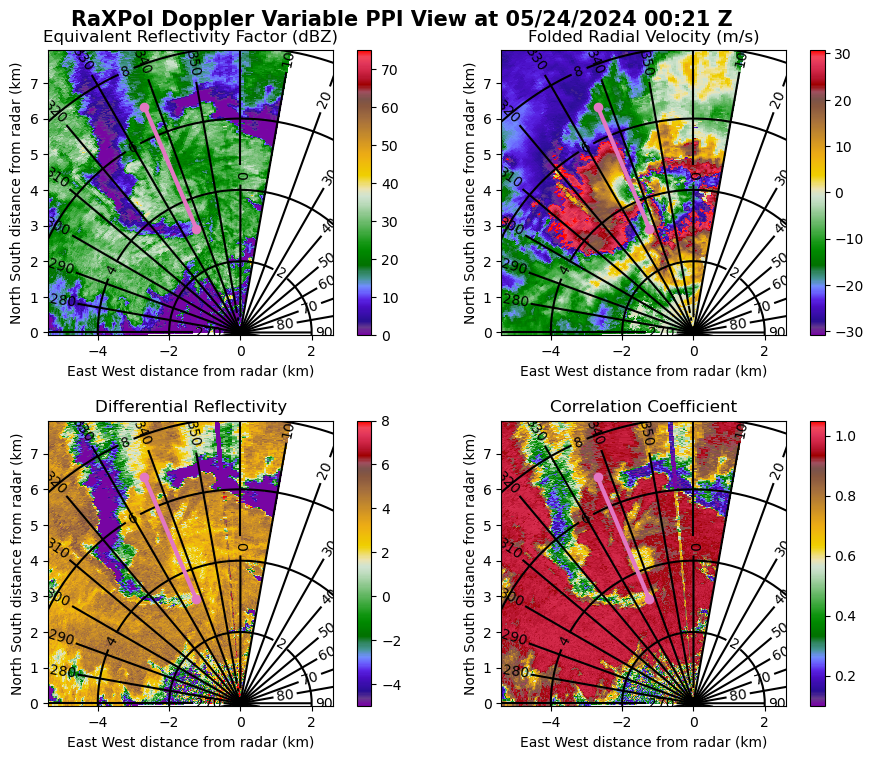

In [295]:
%matplotlib inline
display = pyart.graph.RadarDisplay(radar)
fields_to_plot = {
    'DBZ': {
        'ranges': (0, 75),
        'cmap': 'pyart_Carbone42',
        'title': 'Equivalent Reflectivity Factor (dBZ)'
    },
    'VEL': {
        'ranges': (-radar.get_nyquist_vel(0), radar.get_nyquist_vel(0)),
        'cmap': 'pyart_Carbone42',
        'title': 'Folded Radial Velocity (m/s)'
    },
    'ZDR': {
        'ranges': (-5, 8),
        'cmap': 'pyart_Carbone42',
        'title': 'Differential Reflectivity'
    },
    'RHOHV': {
        'ranges': (0.1, 1.05),
        'cmap': 'pyart_Carbone42',
        'title': 'Correlation Coefficient'
    } 
}

xstart, ystart = radarIQ.misc.coordConvert.polar2cart(range_vals_km[spectrum_range['iranges'][0]], az_vals[spectrum_range['iaz']])
xend, yend = radarIQ.misc.coordConvert.polar2cart(range_vals_km[spectrum_range['iranges'][1]], az_vals[spectrum_range['iaz']])
plt_x = [xstart, xend]
plt_y = [ystart, yend]

half_plot_size = np.ceil(np.abs(np.array(
    [xstart-meso_center['x'], xend-meso_center['x'], ystart-meso_center['y'], yend-meso_center['y']]
)).max()) + 1

xlim = (meso_center['x']-half_plot_size, meso_center['x']+half_plot_size)
ylim = (meso_center['y']-half_plot_size, meso_center['y']+half_plot_size)

xmax = max([abs(i) for i in xlim])
ymax = max([abs(i) for i in xlim])

maxR = np.sqrt(xmax**2 + ymax**2)

plt.figure(figsize=[12, 8])

for plot_num, field in enumerate(fields_to_plot.keys()):
    vmin, vmax = fields_to_plot[field]['ranges']
    cmap = fields_to_plot[field]['cmap']

    plt.subplot(2, 2, plot_num+1)
    plt.axis('scaled')
    display.plot_ppi(field, vmin=vmin, vmax=vmax, cmap=cmap, title_flag=False)
    display.set_limits(xlim=xlim, ylim=ylim)
    display.cbs[plot_num].set_label('')
    plt.title(fields_to_plot[field]['title'])

    rangeRings(rint=2, maxR=maxR, xlims=xlim, ylims=ylim)
    azimuthSpiderweb(azint=10, maxR=maxR, xlims=xlim, ylims=ylim, n=500)

    #line
    plt.scatter(plt_x, plt_y, color='tab:pink')
    plt.plot(plt_x, plt_y, color='tab:pink', linewidth=3)

plt.subplots_adjust(top=0.93, wspace=-0.05, hspace=0.3)
plt.suptitle('RaXPol Doppler Variable PPI View at ' + timeStr, weight='bold', fontsize=15)
plt.savefig(imgDir/'ppi.png', bbox_inches='tight')
plt.show()

In [296]:
#stovepipe outflow side
# r_single = 9.45
r_single = 5
# r_single = 8.75

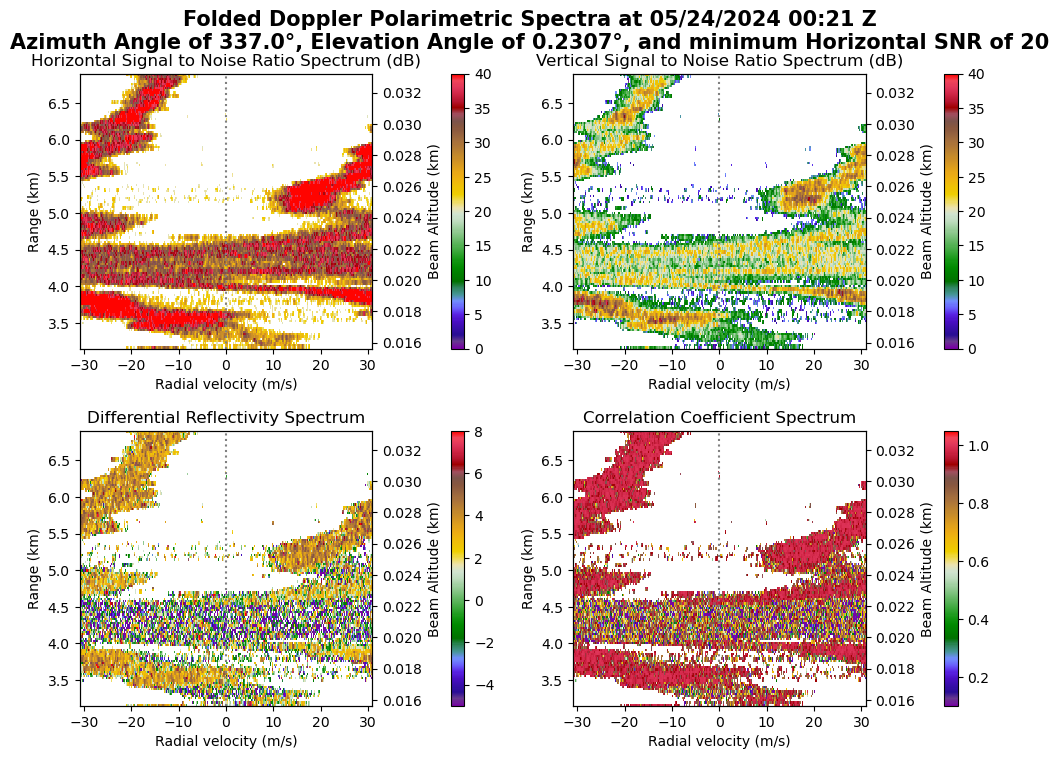

In [300]:
dpsd_fields = {
    'snrh': {
        'title': 'Horizontal Signal to Noise Ratio Spectrum (dB)',
        'data': snrh,
        'ranges': (0, 40),
        'cmap': 'pyart_Carbone42',
    },
    'snrv': {
        'title': 'Vertical Signal to Noise Ratio Spectrum (dB)',
        'data': snrv,
        'ranges': (0, 40),
        'cmap': 'pyart_Carbone42',
    },
    'ZDR': {
        'title': 'Differential Reflectivity Spectrum',
        'data': ZDR,
        'ranges': (-5, 8),
        'cmap': 'pyart_Carbone42',
    },
    'rhoHV': {
        'title': 'Correlation Coefficient Spectrum',
        'data': rhoHV,
        'ranges': (0.1, 1.05),
        'cmap': 'pyart_Carbone42',
    }
}

ny, nx = snrh.shape

r_unique = range_vals_km[spectrum_range["iranges"][0]:spectrum_range["iranges"][1]+1]
el_angle = radar.elevation['data'][spectrum_range['iaz']]
rad_ht_km = radar.altitude['data'][0]/1000
al_unique = np.sqrt((r_unique)**2 + ((4/3)*6371 + rad_ht_km)**2 + 2*r_unique*((4/3)*6371+rad_ht_km)*np.sin(np.radians(el_angle))) - (4/3)*6371

ir = np.argmin(np.abs(r_unique - r_single))
r_single = r_unique[ir]

fig = plt.figure(figsize=[12, 8])
for plot_num, field in enumerate(dpsd_fields.keys()):
    title = dpsd_fields[field]["title"]
    dpsd = dpsd_fields[field]['data']
    vmin, vmax = dpsd_fields[field]['ranges']
    cmap = dpsd_fields[field]['cmap']

    plt.subplot(2, 2, plot_num+1)
    plt.pcolormesh(x_axis, r_unique, dpsd, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.axvline(x=0, color='grey', linestyle=':')
    plt.title(title)
    plt.xlabel('Radial velocity (m/s)')
    plt.ylabel('Range (km)')
    plt.colorbar(pad=0.18)
    plt.axhline(y=r_single)
    plt.twinx()
    plt.ylim([al_unique[0], al_unique[-1]])
    plt.ylabel('Beam Altitude (km)')

plt.subplots_adjust(top=0.9, wspace=0.13, hspace=0.3)
plt.suptitle(
    'Folded Doppler Polarimetric Spectra at ' + timeStr + '\n' +
    'Azimuth Angle of ' + str(az_vals[spectrum_range['iaz']]) + '°, Elevation Angle of ' +
    str(round(el_angle, 4)) + '°, and minimum Horizontal SNR of ' + str(maskval),
    weight='bold', fontsize=15
)
plt.savefig(imgDir/'spectrum.png', bbox_inches='tight')
plt.show()

In [298]:
from scipy.signal import savgol_filter
window = 20
x_href = x_axis[~np.isnan(href[ir])]
href1d = href[ir][~np.isnan(href[ir])]
href1d = savgol_filter(href1d, window, 2)

x_ZDR = x_axis[~np.isnan(ZDR[ir])]
ZDR1d = ZDR[ir][~np.isnan(ZDR[ir])]
ZDR1d = savgol_filter(ZDR1d, window, 2)

x_rhoHV = x_axis[~np.isnan(rhoHV[ir])]
rhoHV1d = rhoHV[ir][~np.isnan(rhoHV[ir])]
rhoHV1d = savgol_filter(rhoHV1d, window, 2)

Text(0.5, 1.0, 'Filtered Doppler Polarimetric Spectra at 05/24/2024 00:21 Z\nAzimuth Angle of 337.0° and Range of 4.995km')

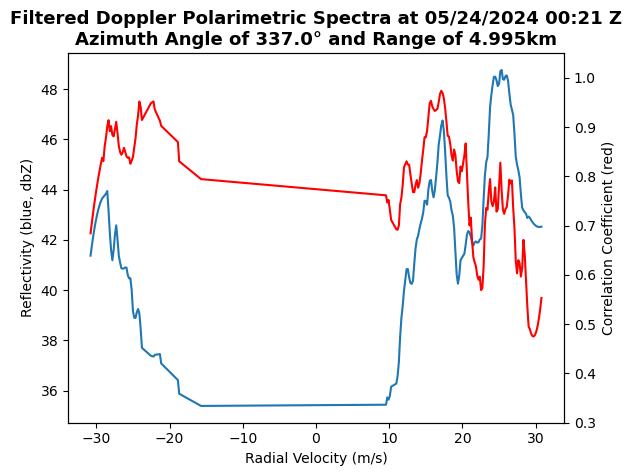

In [299]:
plt.xlabel("Radial Velocity (m/s)")

plt.plot(x_href, href1d)
plt.ylabel("Reflectivity (blue, dbZ)")

plt.twinx()
# plt.plot(x_ZDR, ZDR1d, color='r')
plt.plot(x_rhoHV, rhoHV1d, color='r')
plt.ylim([0.3,1.05])
plt.ylabel("Correlation Coefficient (red)")

plt.title('Filtered Doppler Polarimetric Spectra at ' + timeStr + '\n' +
          'Azimuth Angle of ' + str(az_vals[spectrum_range['iaz']]) + '° and Range of ' +
           str(round(r_single, 4)) + 'km', weight='bold', fontsize=13)